In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(HGNChelper, quietly = T)
    
    library(dplyr, quietly = T)
    library(openxlsx, quietly = T)
    library(reshape2, quietly = T)
    library(data.table, quietly = T)    
    
    library(ggplot2, quietly = T)
    library(ggraph, quietly = T)
    library(ggpubr, quietly = T)
    library(igraph, quietly = T)
    library(RColorBrewer, quietly = T)

})

data_path = '/data/hratch/norcross_abc/'
sctype_path = '/data/hratch/Software/'

In [2]:
bm.integrated<-readRDS(file = paste0(data_path, 'interim/bm.rds'))
md<-bm.integrated@meta.data

# Automated Annotation
Automatically annotate each cluster based on markers using [ScType](http://session.asuscomm.com/sctype_docs/index.html#benefits)

According the the GitHub tutorial, you can used the scaled, integrated counts matrix as input

First, I cloned the github repo (commit ID 36e298c49a57846c8de3f8d1ee58f753d3a9a2a0) into /data2/hratch/Software:

In [3]:
# git clone git@github.com:IanevskiAleksandr/sc-type.git --> commit ID 41d3963b729119d1312468e661367c7a85646f40

In [4]:
# load sc-type functions from locally cloned repo (ensures consistency with version)

source(paste0(sctype_path, 'sc-type/', 'R/gene_sets_prepare.R'))
source(paste0(sctype_path, 'sc-type/', 'R/sctype_score_.R'))       
db_<-paste0(sctype_path, 'sc-type/', 'ScTypeDB_full.xlsx')

# # load from remote      
# source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/gene_sets_prepare.R")
# source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_score_.R")
# db_ = "https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/ScTypeDB_full.xlsx"

In [5]:
path_to_db_file = db_
cell_type = "Immune system" 

cell_markers = openxlsx::read.xlsx(path_to_db_file)
cell_markers = cell_markers[cell_markers$tissueType == cell_type,] 
cell_markers$geneSymbolmore1 = gsub(" ","",cell_markers$geneSymbolmore1); cell_markers$geneSymbolmore2 = gsub(" ","",cell_markers$geneSymbolmore2)

In [6]:
tissue = "Immune system" 
# prepare gene sets
suppressWarnings({
    suppressMessages({
        gs_list = gene_sets_prepare(db_, tissue)
    })
})

The cells can be annotated as any of the following cell types:

In [7]:
intersect(names(gs_list$gs_positive), names(gs_list$gs_negative))

[1] "Pro-B cells"                                 
 [2] "Pre-B cells"                                 
 [3] "Naive B cells"                               
 [4] "Memory B cells"                              
 [5] "Plasma B cells"                              
 [6] "Naive CD8+ T cells"                          
 [7] "Naive CD4+ T cells"                          
 [8] "Memory CD8+ T cells"                         
 [9] "Memory CD4+ T cells"                         
[10] "Effector CD8+ T cells"                       
[11] "Effector CD4+ T cells"                       
[12] "γδ-T cells"                                  
[13] "Platelets"                                   
[14] "CD8+ NKT-like cells"                         
[15] "CD4+ NKT-like cells"                         
[16] "Natural killer  cells"                       
[17] "Eosinophils"                                 
[18] "Neutrophils"                                 
[19] "Basophils"                                   
[20] "Mast cells"                                  
[21] "Classical Monocytes"                         
[22] "Non-classical monocytes"                     
[23] "Intermediate monocytes"                      
[24] "Macrophages"                                 
[25] "Megakaryocyte"                               
[26] "Endothelial"                                 
[27] "Erythroid-like and erythroid precursor cells"
[28] "HSC/MPP cells"                               
[29] "Progenitor cells"                            
[30] "Myeloid Dendritic cells"                     
[31] "Plasmacytoid Dendritic cells"                
[32] "Granulocytes"                                
[33] "ISG expressing immune cells"                 
[34] "Cancer cells"

In [8]:
# get cell-type by cell matrix (scores each cell for each cell type)
es.max = sctype_score(scRNAseqData = bm.integrated@assays$integrated@scale.data, 
                      scaled = TRUE, 
                      gs = gs_list$gs_positive, gs2 = gs_list$gs_negative, 
                      gene_names_to_uppercase = TRUE) 

# merge by cluster by taking the sum of the scores of each cell type
cL_resutls = do.call("rbind", lapply(unique(md$seurat_clusters), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(md[md$seurat_clusters==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(md$seurat_clusters==cl)), 10)
}))

write.csv(cL_resutls, 
         paste0(data_path, 'interim/celltype_cluster_scores_bm.csv'))

# take max score of each cluster
sctype_scores = cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  
sctype_scores[['freq']]<-100*sctype_scores$ncells/sum(sctype_scores$ncells)

sctype_scores[['Confidence']]<-'good'
sctype_scores$Confidence[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "bad"


sctype_scores[with(sctype_scores, order(cluster)), ]

cluster,type,scores,ncells,freq,Confidence
<fct>,<chr>,<dbl>,<int>,<dbl>,<chr>
0,Intermediate monocytes,9619.5382,2546,11.6335390,good
1,Neutrophils,24122.5259,2194,10.0251314,good
2,Neutrophils,8751.1472,1844,8.4258625,good
3,Pre-B cells,15555.5758,1681,7.6810601,good
4,Neutrophils,14819.1818,1416,6.4701851,good
5,Neutrophils,12878.2892,1305,5.9629883,good
6,Myeloid Dendritic cells,2494.7462,958,4.3774275,good
7,CD8+ NKT-like cells,8559.3812,910,4.1580992,good
8,Macrophages,1694.5529,909,4.1535298,good


A cluster annotation has "low" confidence if the ScType score is < 0 or < 0.25*# of cells in that cluster. ScType annotates these as unknown, s.t. seemingly not enough information is available in the transcriptomics data and markers database. We will want to double check these and perhaps keep them labelled as Unknown. 

In [9]:
sctype_scores$type

[1] "Erythroid-like and erythroid precursor cells"
 [2] "Erythroid-like and erythroid precursor cells"
 [3] "Intermediate monocytes"                      
 [4] "Erythroid-like and erythroid precursor cells"
 [5] "Neutrophils"                                 
 [6] "Neutrophils"                                 
 [7] "ISG expressing immune cells"                 
 [8] "Pre-B cells"                                 
 [9] "Neutrophils"                                 
[10] "Macrophages"                                 
[11] "Naive B cells"                               
[12] "Neutrophils"                                 
[13] "Naive B cells"                               
[14] "Pro-B cells"                                 
[15] "Progenitor cells"                            
[16] "Myeloid Dendritic cells"                     
[17] "Myeloid Dendritic cells"                     
[18] "Macrophages"                                 
[19] "Pro-B cells"                                 
[20] "HSC/MPP cells"                               
[21] "CD8+ NKT-like cells"                         
[22] "Neutrophils"                                 
[23] "Granulocytes"                                
[24] "Macrophages"                                 
[25] "Naive B cells"                               
[26] "Basophils"                                   
[27] "Platelets"

In [10]:
# assign cell types to barcodes 
mapper<-setNames(sctype_scores$type, sctype_scores$cluster)
md[['Cell.Type.ScType']]<-unlist(unname(mapper[as.character(md$seurat_clusters)]))


# co<-c('Progenitor cells', 'Naive B cells', 'Pre-B cells', 'γδ-T cells', 
#       'Naive CD4+ T cells', 'Effector CD4+ T cells', 
#       'Naive CD8+ T cells', 'Effector CD8+ T cells', 'Memory CD8+ T cells',
#       'CD4+ NKT-like cells', 'CD8+ NKT-like cells', 'Natural killer  cells',
#      'Myeloid Dendritic cells', 'Plasmacytoid Dendritic cells', 
#       'Non-classical monocytes', 'Macrophages',
#      'Basophils', 'Eosinophils', 'Neutrophils')

# md[['Cell.Type.ScType']]<-factor(x = md$Cell.Type.ScType,levels = co)
# retain individual barcode scores
md<-cbind(md, t(es.max[, rownames(md)]))
write.csv(md, paste0(data_path, 'interim/celltype_md_bm.csv'))
bm.integrated@meta.data<-md

Let's see what the distribution of scores was for the annotations:

In [19]:
# viz.df<-md[!colnames(md) %in% colnames(md)[c(1,2,3,4,5, 7)]]
# viz.df<-melt(viz.df, value.name = 'Annotation.Score')
# colnames(viz.df)<-c('seurat_clusters', 'Cell.Type', 'Annotation.Score')

# h_ = 50
# w_ = 30
# options(repr.plot.height=h_, repr.plot.width=w_)
# g1<-ggplot(data = viz.df, aes(x = Cell.Type, y = Annotation.Score)) + geom_violin() + 
# facet_wrap(~seurat_clusters, ncol = 2)+
# theme(axis.text.x = element_text(angle = 45))

# g1

Non-leaf weights ignored
Warning message in geom_node_text(aes(filter = ord == 2, label = shortName, colour = I("#ffffff"), :
“Ignoring unknown aesthetics: fill, repel, and parse”
Warning message in geom_node_label(aes(filter = ord == 1, label = shortName, colour = I("#000000"), :
“Ignoring unknown aesthetics: parse”


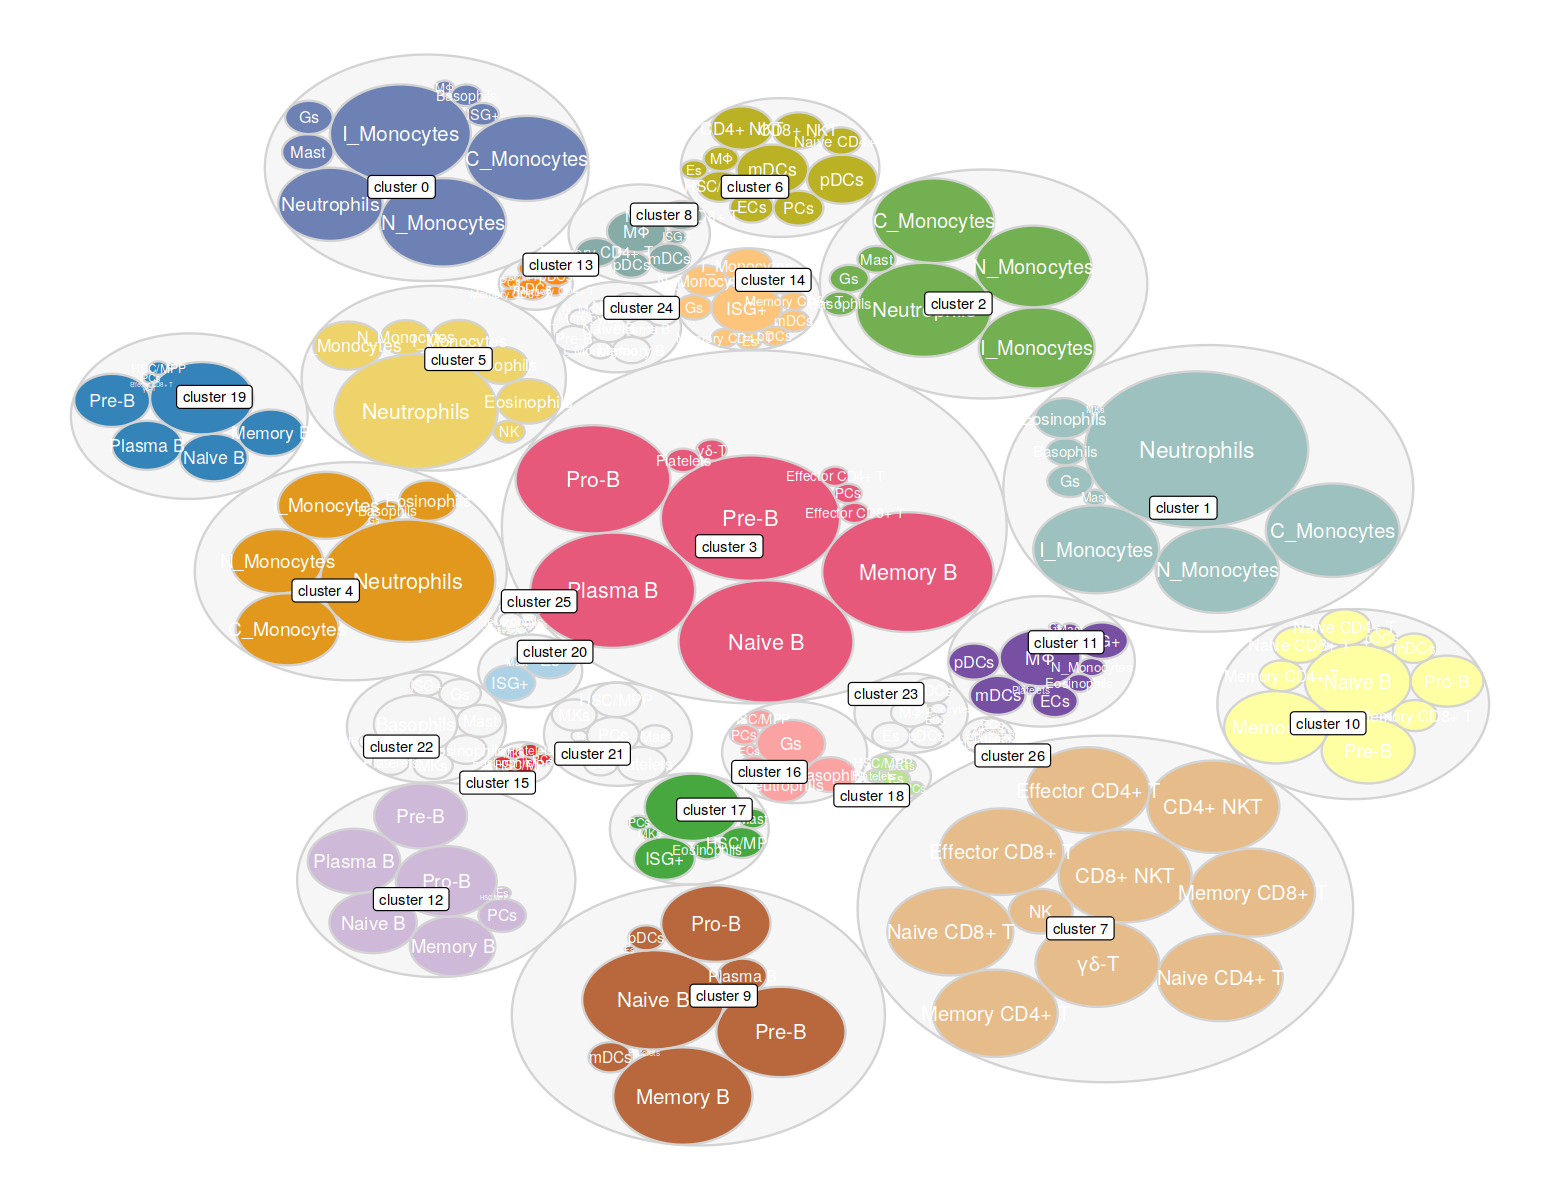

In [37]:
# prepare edges
cL_resutls=cL_resutls[order(cL_resutls$cluster),]; edges = cL_resutls; edges$type = paste0(edges$type,"_",edges$cluster); edges$cluster = paste0("cluster ", edges$cluster); edges = edges[,c("cluster", "type")]; colnames(edges) = c("from", "to"); rownames(edges) <- NULL

# prepare nodes
nodes_lvl1 = sctype_scores[,c("cluster", "ncells")]; nodes_lvl1$cluster = paste0("cluster ", nodes_lvl1$cluster); nodes_lvl1$Colour = "#f1f1ef"; nodes_lvl1$ord = 1; nodes_lvl1$realname = nodes_lvl1$cluster; nodes_lvl1 = as.data.frame(nodes_lvl1); nodes_lvl2 = c(); 
ccolss= c("#5f75ae","#92bbb8","#64a841","#e5486e","#de8e06","#eccf5a","#b5aa0f","#e4b680","#7ba39d","#b15928","#ffff99", "#6a3d9a","#cab2d6","#ff7f00","#fdbf6f","#e31a1c","#fb9a99","#33a02c","#b2df8a","#1f78b4","#a6cee3")
for (i in 1:length(unique(cL_resutls$cluster))){
  dt_tmp = cL_resutls[cL_resutls$cluster == unique(cL_resutls$cluster)[i], ]; nodes_lvl2 = rbind(nodes_lvl2, data.frame(cluster = paste0(dt_tmp$type,"_",dt_tmp$cluster), ncells = dt_tmp$scores, Colour = ccolss[i], ord = 2, realname = dt_tmp$type))
}
nodes = rbind(nodes_lvl1, nodes_lvl2); nodes$ncells[nodes$ncells<1] = 1;
files_db = openxlsx::read.xlsx(db_)[,c("cellName","shortName")]; files_db = unique(files_db); nodes = merge(nodes, files_db, all.x = T, all.y = F, by.x = "realname", by.y = "cellName", sort = F)
nodes$shortName[is.na(nodes$shortName)] = nodes$realname[is.na(nodes$shortName)]; nodes = nodes[,c("cluster", "ncells", "Colour", "ord", "shortName", "realname")]

mygraph <- graph_from_data_frame(edges, vertices=nodes)

# Make the graph
gggr<- ggraph(mygraph, layout = 'circlepack', weight=I(ncells)) + 
  geom_node_circle(aes(filter=ord==1,fill=I("#F5F5F5"), colour=I("#D3D3D3")), alpha=0.9) + geom_node_circle(aes(filter=ord==2,fill=I(Colour), colour=I("#D3D3D3")), alpha=0.9) +
  theme_void() + geom_node_text(aes(filter=ord==2, label=shortName, colour=I("#ffffff"), fill="white", repel = !1, parse = T, size = I(log(ncells,25)*1.5)))+ geom_node_label(aes(filter=ord==1,  label=shortName, colour=I("#000000"), size = I(3), fill="white", parse = T), repel = !0, segment.linetype="dotted")


h_ = 10
w_ = 13
options(repr.plot.height=h_, repr.plot.width=w_)
gggr
# scater::multiplot(DimPlot(pbmc, reduction = "umap", label = TRUE, repel = TRUE, cols = ccolss), gggr, cols = 2)

Let's look at distributions of scores for the cell type that was actually assigned to each cluster:

In [23]:
# # filter for the score that was assigned
# retain.idx<-c()
# for (cluster in names(mapper)){
#     retain.idx<-c(retain.idx, 
#                   rownames(viz.df[(viz.df$seurat_clusters == cluster) & (viz.df$Cell.Type == mapper[cluster]), ]))
# }
# viz.df<-viz.df[retain.idx,]

# h_ = 5
# w_ = 15
# options(repr.plot.height=h_, repr.plot.width=w_)
# g2<-ggplot(data = viz.df, aes(x = seurat_clusters, y = Annotation.Score)) + geom_violin() 

# g2

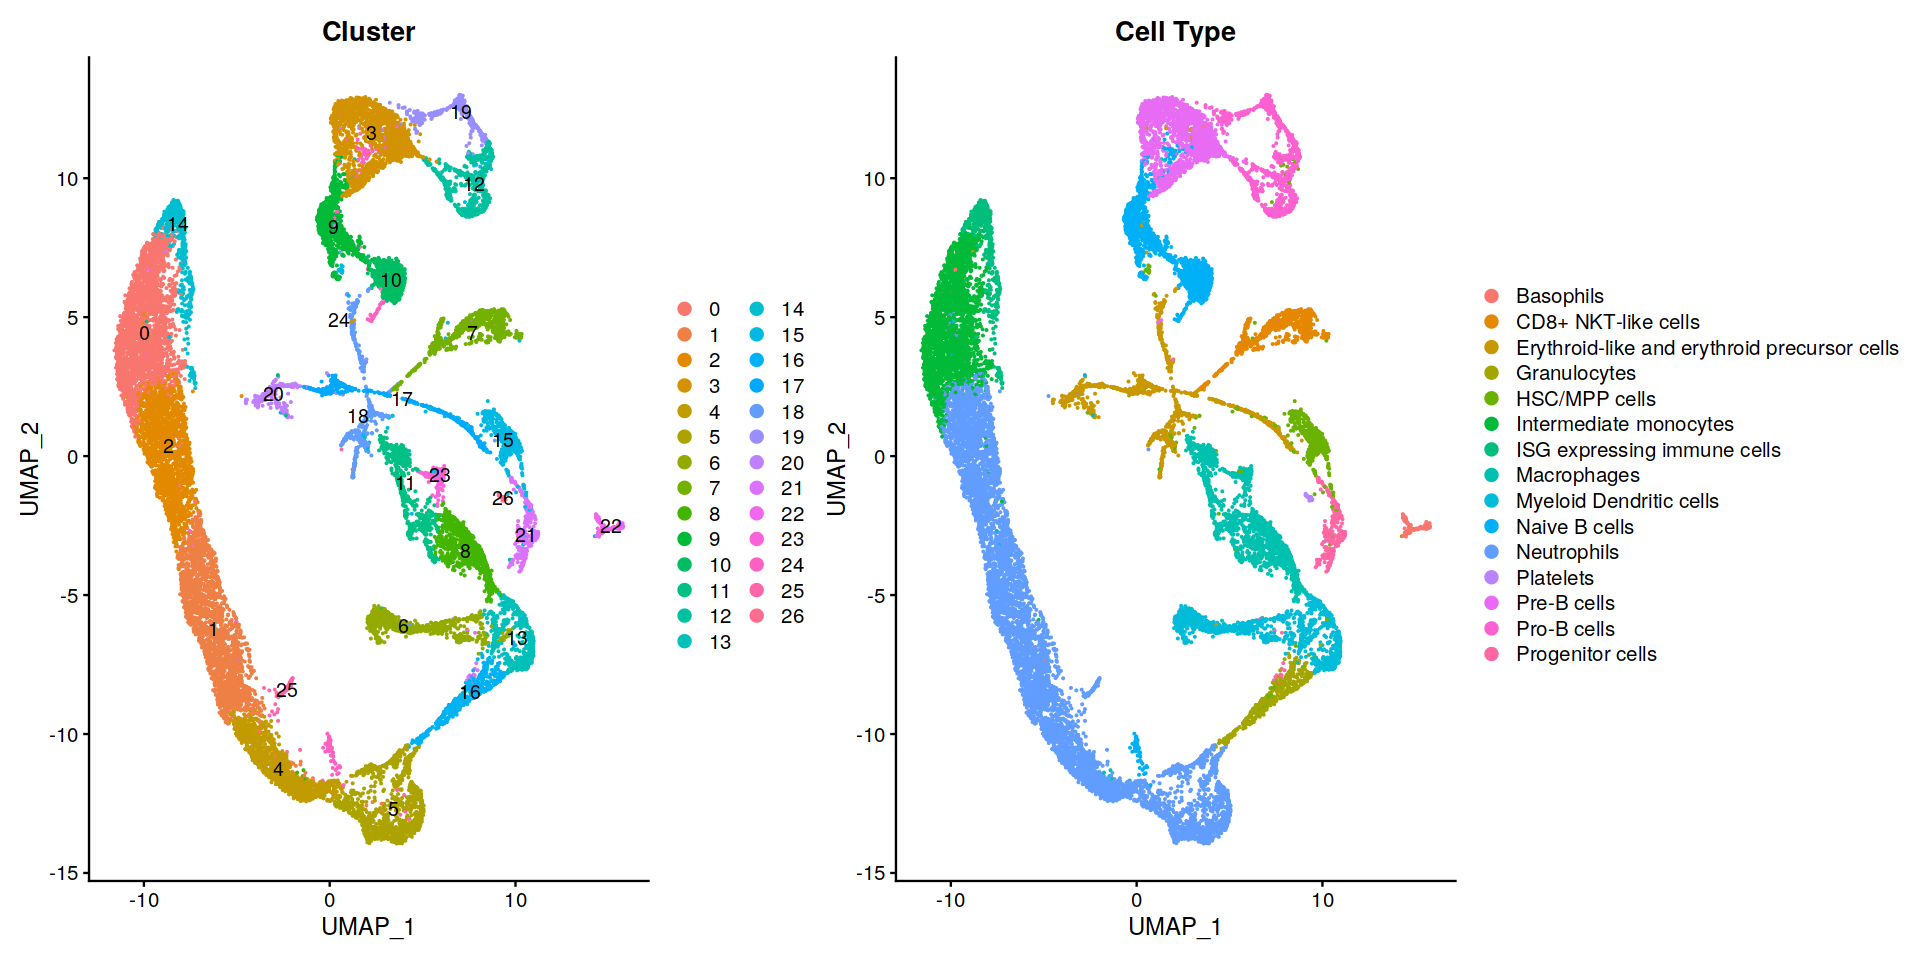

In [38]:
h_ = 8
w_ = 16
options(repr.plot.height=h_, repr.plot.width=w_)
g3a <- DimPlot(bm.integrated, reduction = "umap", group.by = "seurat_clusters", shuffle = T, label = T)+
ggtitle('Cluster')
g3c <- DimPlot(bm.integrated, reduction = "umap", group.by = "Cell.Type.ScType", shuffle = T,  label = F)+
ggtitle('Cell Type')

g3<-g3a + g3c
# for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
#                                                      'UMAP_cluster_celltype_bm', ext), g3)}     
g3

Let's see whether the many-to-one mappings from cluster to cell type label are for clusters near each other in UMAP space or far apart. We will want to double check the ones that are far apart. 

In [39]:
# md<-bm.integrated@meta.data
# md_og<-bm.integrated@meta.data


# cluster.label<-'seurat_clusters'
# unique.cell.cluster<-md[!duplicated(md[c(cluster.label, 'Cell.Type.ScType')]), ]
# celltypes.multiple<-names(which(table(unique.cell.cluster$Cell.Type.ScType) > 1))
# print('The following cells are labelled in more than one cluster: ')
# celltypes.multiple

In [40]:
# # label according to both 
# parse.cluster<-function(y, x){
#     if (y %in% celltypes.multiple){
#         return(paste0(y, ' - ', x))
#     }else{
#         return(as.character(y))
#     }
# }
# md[['Cell.Type.uniquecluster']]<-mapply(parse.cluster, md$Cell.Type.ScType, md[[cluster.label]])


# co<-c('Progenitor cells', 'Naive B cells', 'Pre-B cells - 1', 'Pre-B cells - 20', 'Pre-B cells - 26', 'γδ-T cells', 
#       'Naive CD4+ T cells', 'Effector CD4+ T cells', 
#       'Naive CD8+ T cells', 'Effector CD8+ T cells', 'Memory CD8+ T cells',
#       'CD4+ NKT-like cells', 'CD8+ NKT-like cells', 'Natural killer  cells - 19', 'Natural killer  cells - 13', 
#      'Myeloid Dendritic cells - 4', 'Myeloid Dendritic cells - 9', 'Myeloid Dendritic cells - 14', 
#       'Myeloid Dendritic cells - 18', 
#       'Plasmacytoid Dendritic cells - 11', 'Plasmacytoid Dendritic cells - 22',
#       'Non-classical monocytes', 'Macrophages - 7','Macrophages - 17',
#      'Basophils', 'Eosinophils', 'Neutrophils')
# md[['Cell.Type.uniquecluster']]<-factor(x = md$Cell.Type.uniquecluster,levels = co)


# mapper<-setNames(1:length((unique(md$Cell.Type.uniquecluster))), sort(unique(md$Cell.Type.uniquecluster)))
# md[['Cell.Type.forUMAP']]<-unname(unlist(mapper[md[['Cell.Type.uniquecluster']]]))
# md[['Cell.Type.forUMAP']]<-factor(x = md$Cell.Type.forUMAP,
#                                         levels = sort(unique(md[['Cell.Type.forUMAP']])))
# legend.labels<-paste0(unname(unlist(mapper)), ': ', names(mapper))

# bm.integrated@meta.data<-md

Annotation: "#: Cell Type - Cluster Label"
* "#" maps the label on the UMAP plot to the legend
* "Cell Type" is the annotated cell type 
* "Cluster Label" is the "seurate_cluster_let" label, if the cell type mapped to more than one cluster

In [41]:
# h_ = 7
# w_ = 16
# options(repr.plot.height=h_, repr.plot.width=w_)

# colors = c(brewer.pal(n=12, "Set3"),
#            brewer.pal(n=8, "Dark2"), 
#            brewer.pal(n=7, "Accent"))
# theme = theme(panel.background = element_blank(), panel.border = element_rect(colour = 'black', fill = 'NA'),
#          text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
#           axis.title=element_text(size=28), legend.text=element_text(size=16), 
#          legend.title=element_text(size=20), axis.text.x = element_text(size = 22), 
#              axis.text.y = element_text(size = 22)) 

# g4<-DimPlot(bm.integrated, reduction = 'umap',  
#             group.by = 'Cell.Type.forUMAP', label = T)+
#     xlab('UMAP 1')+ylab('UMAP 2')+
#     scale_color_manual(values = colors, labels = legend.labels) + labs(color='Cell Type')+theme+
#     ggtitle('Cell Types (Clusters distinguished)')
# g4

In [42]:
# h_ = 7
# w_ = 16
# options(repr.plot.height=h_, repr.plot.width=w_)
# gQC1<-ggplot(data = bm.integrated@meta.data, 
#              aes(y = percent.mt, x = seurat_clusters, fill = seurat_clusters))+geom_violin()+
#             scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
#             theme_bw()
# gQC1

In [43]:
# h_ = 7
# w_ = 16
# options(repr.plot.height=h_, repr.plot.width=w_)
# gQC2<-ggplot(data = bm.integrated@meta.data, 
#              aes(y = nCount_RNA, x = seurat_clusters, fill = seurat_clusters))+geom_violin()+
#             scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 1e4),1))+
#             theme_bw()
# gQC2

# Dotplot

Dotplot of each marker to double check that annotated cell types make sense.

In [45]:
markers<-unname(unlist(gs_list$gs_positive))

print(paste0('The total number of unique markers is: ', length(markers)))

markers.present<-intersect(markers, toupper(rownames(bm.integrated)))
print(paste0('The total number of unique markers in the HVGs: ', length(markers.present)))
fwrite(as.list(markers.present), paste0(data_path, 'interim/scType_pos_markers.txt'))

[1] "The total number of unique markers is: 720"
[1] "The total number of unique markers in the HVGs: 153"


In [46]:
markers.present<-rownames(bm.integrated)[toupper(rownames(bm.integrated)) %in% markers] # keep mouse gene name

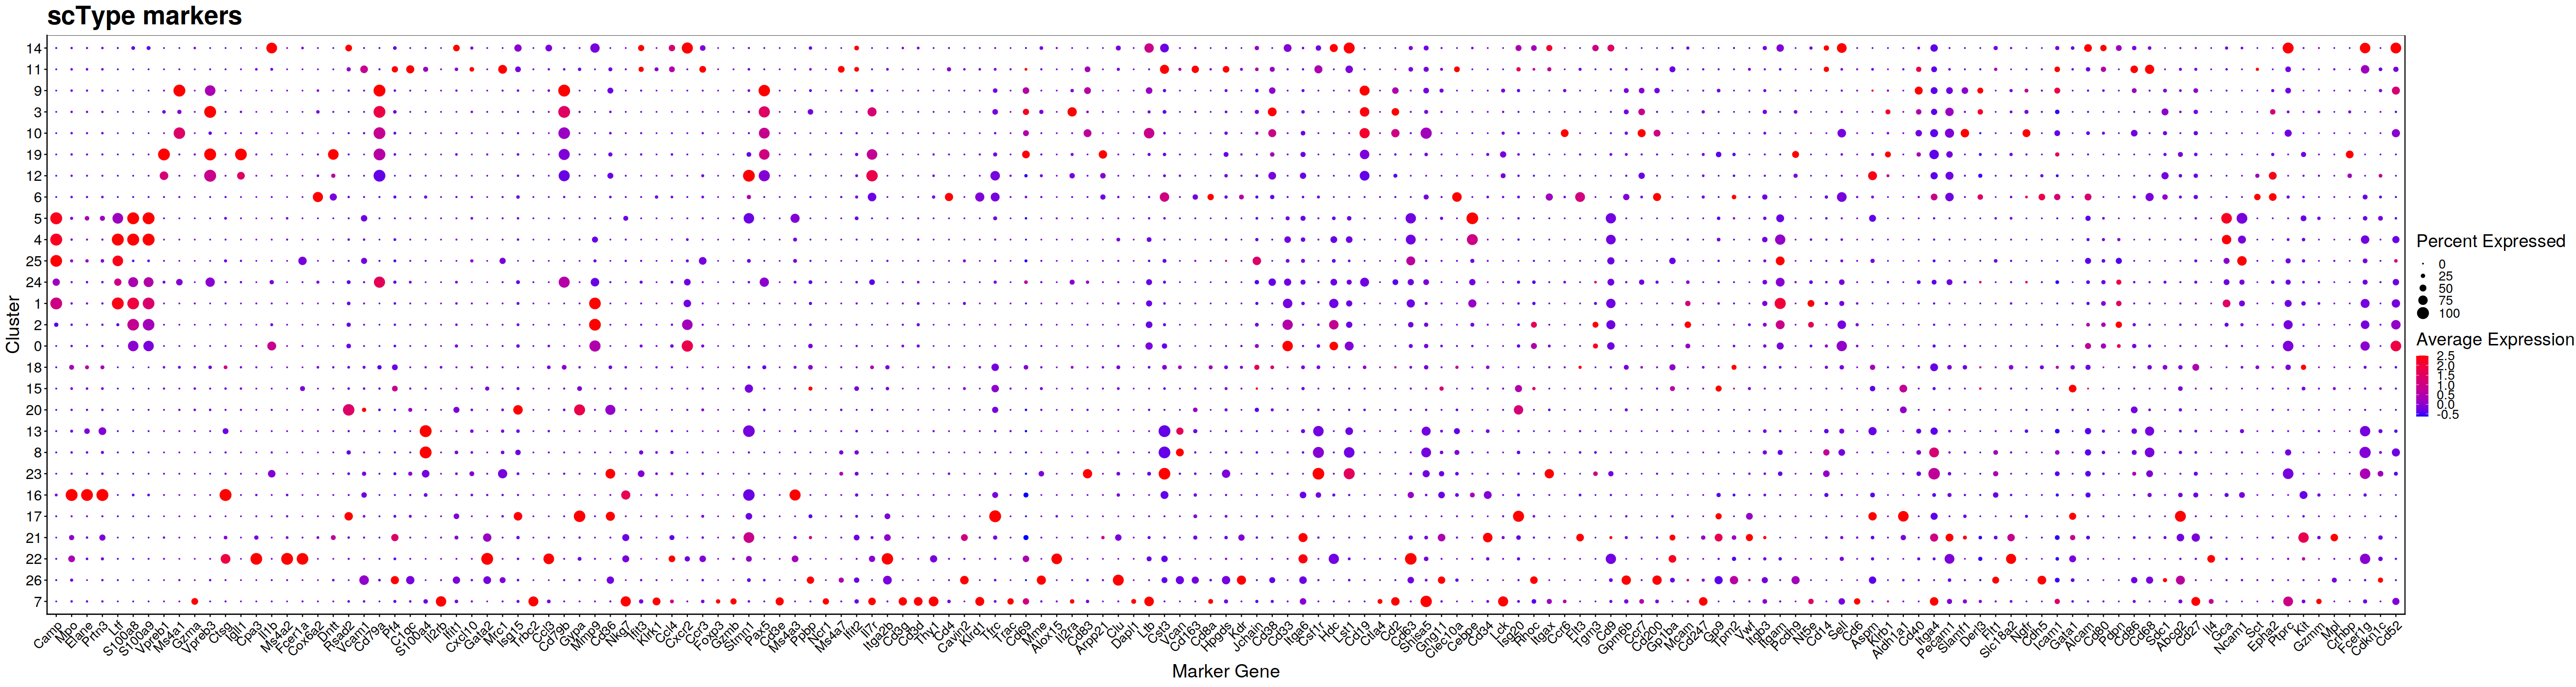

In [47]:
h_ = 12
w_ = 45
options(repr.plot.height=h_, repr.plot.width=w_)

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=23), legend.text=element_text(size=16), 
         legend.title=element_text(size=22), axis.text.y = element_text(size = 18), 
              legend.key = element_blank(),
             axis.text.x = element_text(size = 16))
suppressWarnings({
    g<-DotPlot(bm.integrated, features = markers.present, cols = c('blue', 'red'), cluster.idents = T) + 
    RotatedAxis()+
    xlab('Marker Gene') + ylab('Cluster') + theme + ggtitle("scType markers")
})

# for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
#                                                      'scType_marker_dotplot_bm', ext), g, 
#                                              height = h_, width = w_)}

g


# Cluster Markers

Identify markers for each cluster to double check that annotated cell types make sense and re-annotate low-confidence cell types/those that were annotated across disparate clusters. 

According to [this study](https://www.nature.com/articles/s41467-021-25960-2), there is not high concordance in methods, but Wilcoxon rank-sum is the most commonly used (and Seurat's default) and there is no need to account for confounders since we are considering all cells across batch. 

In [101]:
# # # Wilcoxon
# # # normalized counts as recommended by 
# # # https://github.com/satijalab/seurat/issues/2636
# # # https://github.com/satijalab/seurat/discussions/4000
# # markers.wilcoxon<-FindAllMarkers(object = bm.integrated, assay = 'RNA', only.pos = T, 
# #                                 slot = 'data', test.use = 'wilcox', 
# #                                 min.pct = 0.25, # stringent since markers
# #                                 logfc.threshold = 0.5 
# #                                   )
# # saveRDS(markers.wilcoxon, paste0(data_path, 'interim/cluster_markers_wilcoxon.RDS'))

# markers<-readRDS(paste0(data_path, 'interim/cluster_markers_wilcoxon.RDS'))

In [126]:
# markers<-readRDS(paste0(data_path, 'interim/cluster_markers_wilcoxon.RDS'))

In [129]:
# # format markers
# markers.excel<-function(marker, de.type){
#     markers_workbook<-createWorkbook()
#     for (cluster in sort(unique(marker$cluster))){
#         de.res.cl<-as.data.frame(marker[marker$cluster == cluster, ])
#         rownames(de.res.cl)<-1:dim(de.res.cl)[[1]]

#     #     # make infinites characlers, otherwise writes as NULL
#     #     idx_<-as.numeric(rownames(de.res.cl[is.infinite(de.res.cl$LFC), ]))

#         addWorksheet(markers_workbook, cluster)
#         writeData(markers_workbook, sheet = cluster, x = de.res.cl)
#     }
#     saveWorkbook(markers_workbook, overwrite = T, 
#                  paste0(data_path, 'interim/', de.type, '_markers.xlsx'))
# }

# counter<-1
# suppressMessages({
#     suppressWarnings({
#         de.type<-'wilcoxon'
#         markers<-markers[markers$p_val_adj <= 0.1,] # threshold on p_adj
#         markers<-markers[markers$avg_log2FC > 0.75,] # further threshold on LFC
#         markers<-markers[with(markers, order(cluster, -avg_log2FC)), ] # sort by effect size

#         markers[['scType.annotation']]<-unlist(unname(mapper[as.character(markers$cluster)]))

#         markers.excel(markers, de.type) # save to excel file

#     })
# })

In [132]:
# saveRDS(bm.integrated, 
#         file = paste0(data_path, 'interim/abc_sctype_annotated.RDS'))